In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon

*The goal of our project is to analyze metadata from messaging groups in order to gain insights about the information being exchanged.*<br> *To accomplish this, we recorded the traffic from four different WhatsApp Web groups, each exhibiting distinct characteristics:*

*Group A: Only picture messages were sent within this group.<br>
Group B: Only long text messages were exchanged in this group.<br>
Group C: This group contained only video file transfers between members.<br>
Group D: Audio files were the sole media type sent in this group.<br>
This diversity in group traffic composition allowed us to analyze whether unique fingerprints emerged in the timing and size patterns for different content types.<br>*

*Additionally, we captured a second dataset from Group A. In this new capture, while still only sending pictures, we added background "noise" by streaming music on Spotify concurrently.<br> By comparing this noisy capture to the initial clean Group A traffic, we could examine the impact of mixed media streams on identifying underlying messaging patterns.<br>*

*We also captured a third dataset from different groups mixed together.In this new capture we sent two pictures, one video and one long message.<br> We tried to understand from this how different times look next to each other.*

In [2]:
def plot_graph(data_frame, graph_title):
    """
    Plot a stem graph using data from the provided DataFrame.
    """
    # Extract data from the DataFrame
    time_values = data_frame['Time']
    length_values = data_frame['Length']
    
    # Create a new figure
    plt.figure(figsize=(15, 6)) 
    
    # Plot the stem graph
    plt.stem(time_values, length_values, linefmt='black', markerfmt=' ', basefmt='black')
    
    # Set labels and title
    plt.xlabel('Time')
    plt.ylabel('Length')
    plt.title(graph_title, fontsize=15)
    
    # Display the graph
    plt.show()

In [3]:
def plot_pdf(data_frame):
    """
    Plot the Probability Density Function (PDF) of inter-message delays and its fitted exponential distribution.
    """
    
    plt.figure(figsize=(6,3)) 
    # Extract inter-message delays
    inter_message_delays =  data_frame['Time'].diff().shift(-1)
    inter_message_delays.dropna(inplace=True)    
    # Plot histogram
    plt.hist(inter_message_delays, bins=200, density=True, histtype='step', color='blue')
    
    # Fit exponential distribution
    param = expon.fit(inter_message_delays)
    x = np.linspace(0, inter_message_delays.max(), 100)
    fitted_pdf = expon.pdf(x, *param) 
    
    # Plot fitted exponential PDF
    plt.plot(x, fitted_pdf, 'r-', lw=2)  
    
    # Labels and legend
    plt.title('PDF of Inter-Message Delays and Its Fitted Exponential Distribution')
    plt.xlabel('Inter-Message Delays (Seconds)')  
    plt.ylabel('PDF')
    plt.legend(['Histogram of Inter-Message Delays', 'Fitted Exponential Distribution']) 
    
    plt.show()

In [4]:
def plot_hist(data_frame, max_range, graph_title):
    """
    Plot a histogram of the given data within the specified range.
    """
    
    data_diff = data_frame['Time'].diff().shift(-1)
    
    bins = range(0, max_range) 
    plt.figure(figsize=(6,3)) 
    
    # Plot histogram
    plt.hist(data_diff, bins=bins, color='yellow', edgecolor='black')
    
    # Labels and title
    plt.xlabel('Time Difference')
    plt.ylabel('Frequency')
    plt.title(graph_title)
    
    # Show plot
    plt.show()

*After capturing the data by filtering on tcp.port=443, we tried to understand how we could further filter the data to obtain the relevant packets.<br> Therefore, we decided to filter the data based on the IP address of our computer and the IP address of the WhatsApp web server.<br>*

*By only looking at packets sent between our computer and the WhatsApp server, we aimed to isolate the metadata specific to our WhatsApp web usage.<br> This should allow us to analyze messaging patterns, message frequency, and other relevant metrics for our account.<br>*

*Filtering out other extraneous network traffic that is not related to our WhatsApp web session helps reduce noise in the data and lets us focus our analysis specifically on our own WhatsApp messaging metadata.<br> The goal is to get clean, targeted data that contains the information we need about our chat patterns and communication.*

### Pictures Group

In [28]:
pictures_data = pd.read_csv("../resources/Pictures Group/pictures_data.csv")
# pictures_data = pictures_data.loc[pictures_data['Length'] > 200] 
pictures_data = pictures_data.loc[
    (pictures_data['Source'] == '2a03:2880:f258:c8:face:b00c:0:167') & 
    (pictures_data['Destination'] == '2a00:a041:3c5d:4d00:b981:f170:feac:7cf9')
]
pictures_data

,No.,Time,Source,Destination,Protocol,Length,Info
1,5,9.821193,2a03:2880:f258:c8:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TCP,1468,443 > 39412 [ACK] Seq=1 Ack=1 Win=1364 Len=1...
2,6,9.821505,2a03:2880:f258:c8:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TLSv1.2,164,Application Data
5,13,10.045411,2a03:2880:f258:c8:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TCP,88,443 > 39412 [ACK] Seq=1457 Ack=71 Win=1364 L...
6,14,10.114095,2a03:2880:f258:c8:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TLSv1.2,160,Application Data
8,16,10.127036,2a03:2880:f258:c8:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TCP,1468,443 > 39412 [ACK] Seq=1529 Ack=71 Win=1364 L...
...,...,...,...,...,...,...,...
4647,5129,598.549289,2a03:2880:f258:c8:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TLSv1.2,368,Application Data
4650,5132,598.634331,2a03:2880:f258:c8:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TCP,88,443 > 39412 [ACK] Seq=128189 Ack=29708 Win=1...
4652,5134,602.860882,2a03:2880:f258:c8:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TCP,88,443 > 39412 [ACK] Seq=128189 Ack=29778 Win=1...
4653,5135,603.054549,2a03:2880:f258:c8:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TLSv1.2,160,Application Data


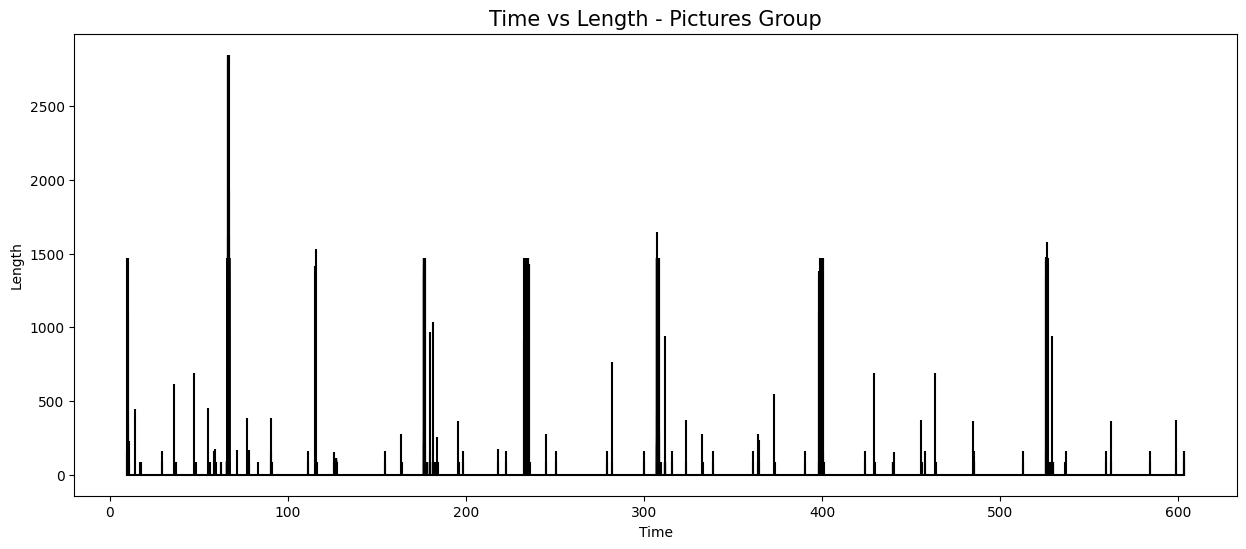

In [29]:
plot_graph(pictures_data,'Time vs Length - Pictures Group')

*In order to differentiate noise from actual image data, we conducted an experiment three times where a single image was transmitted through a messaging group.<br>
By analyzing the resulting packet size distributions, it was determined that packets smaller than 200 bytes in size did not contain any meaningful image data and could be classified as noise.* 

In [30]:
picture_check1 = pd.read_csv("../resources/Picture threshold//picture_check1_data.csv", encoding='latin-1')

picture_check2 = pd.read_csv("../resources/Picture threshold/picture_check2_data.csv", encoding='latin-1')

picture_check3 = pd.read_csv("../resources/Picture threshold/picture_check3_data.csv", encoding='latin-1')

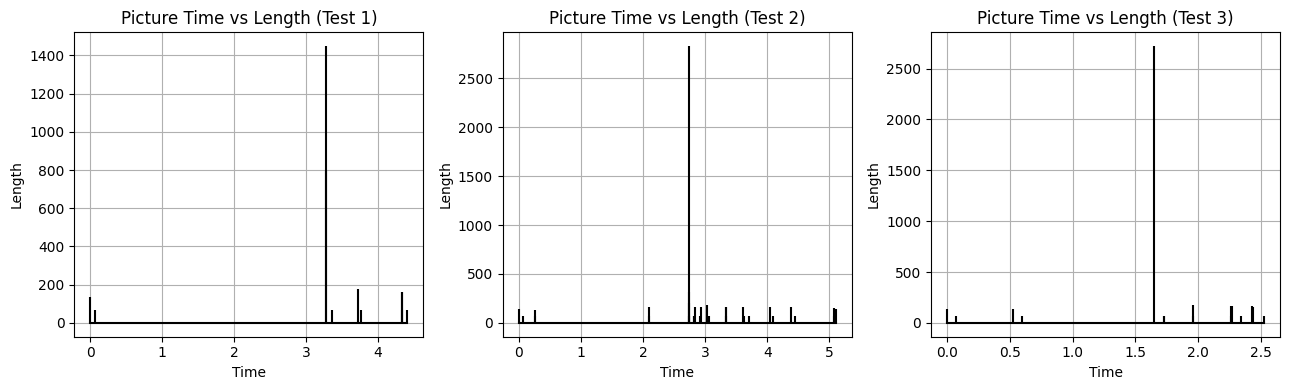

In [31]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13,4)) 

test1_time = picture_check1['Time']
test1_length = picture_check1['Length']
ax1.stem(test1_time, test1_length, linefmt ='black', markerfmt = '', basefmt='black')
ax1.set_xlabel('Time')
ax1.set_ylabel('Length')
ax1.set_title('Picture Time vs Length (Test 1)')
ax1.grid()

test2_time = picture_check2['Time']
test2_length = picture_check2['Length']
ax2.stem(test2_time, test2_length, linefmt ='black', markerfmt = '', basefmt='black') 
ax2.set_xlabel('Time')
ax2.set_ylabel('Length')
ax2.set_title('Picture Time vs Length (Test 2)')
ax2.grid()

test3_time = picture_check3['Time']
test3_length = picture_check3['Length']
ax3.stem(test3_time, test3_length, linefmt ='black', markerfmt = '', basefmt='black') 
ax3.set_xlabel('Time')
ax3.set_ylabel('Length')
ax3.set_title('Picture Time vs Length (Test 3)')
ax3.grid()

fig.tight_layout()
plt.show()

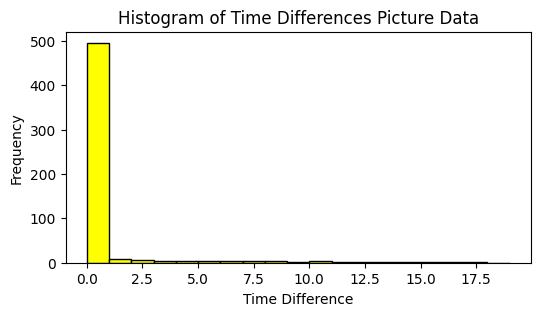

In [32]:
plot_hist(pictures_data, 20, 'Histogram of Time Differences Picture Data')

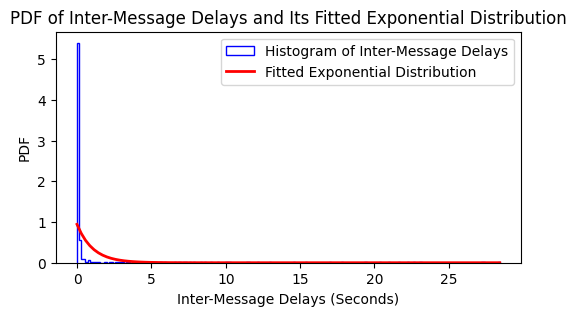

In [33]:
plot_pdf(pictures_data)

### Video Group 

In [34]:
video_data = pd.read_csv("../resources/Video Group/video_data.csv", encoding='latin-1')
video_data = video_data.loc[
    (video_data['Source'] == '2a03:2880:f258:c8:face:b00c:0:167') & 
    (video_data['Destination'] == '2a00:a041:3c5d:4d00:b981:f170:feac:7cf9')
]
video_data.head()

,No.,Time,Source,Destination,Protocol,Length,Info
0,1,0.000000,2a03:2880:f258:c8:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TLSv1.2,160,Application Data
3,26,29.038825,2a03:2880:f258:c8:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TCP,88,443 > 39412 [ACK] Seq=73 Ack=71 Win=1649 Len...
4,27,29.121224,2a03:2880:f258:c8:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TLSv1.2,160,Application Data
6,40,48.680053,2a03:2880:f258:c8:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TLSv1.2,311,Application Data
10,44,49.065612,2a03:2880:f258:c8:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TCP,88,443 > 39412 [ACK] Seq=368 Ack=145 Win=1649 L...


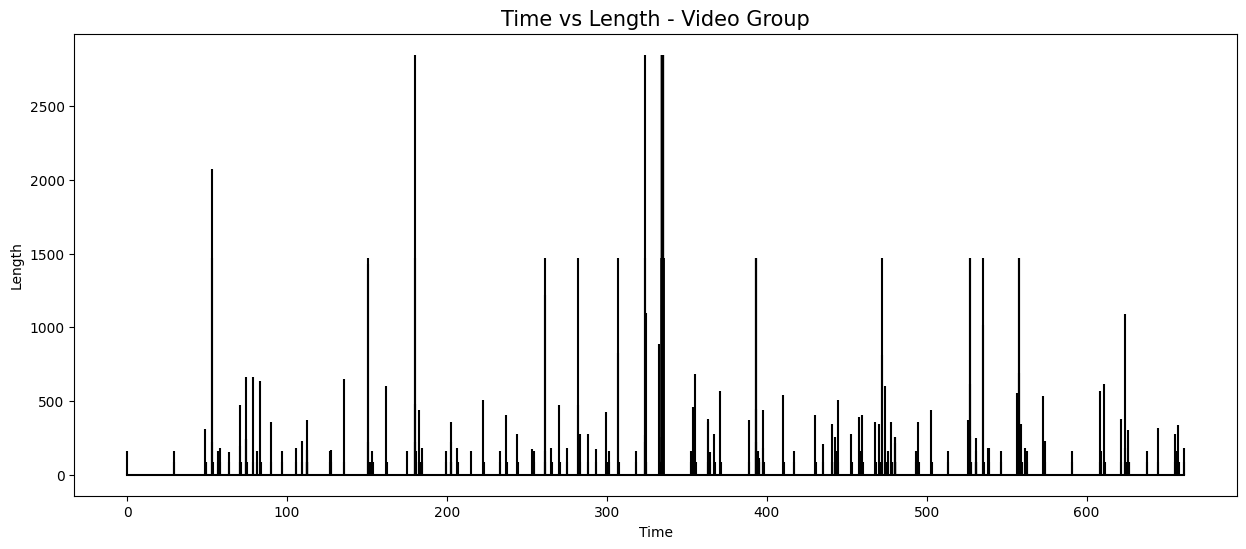

In [35]:
plot_graph(video_data,'Time vs Length - Video Group')

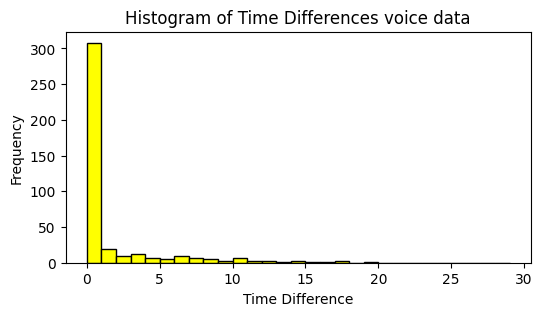

In [36]:
plot_hist(video_data,30, 'Histogram of Time Differences voice data')

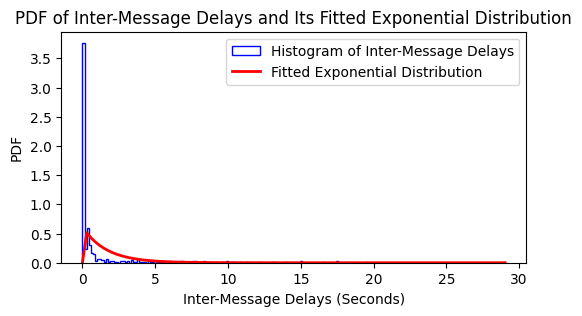

In [37]:
plot_pdf(video_data)

### Voice Group 

In [43]:
voice_data = pd.read_csv("../resources/Adiuo Group/adiuo_data.csv")
voice_data = voice_data.loc[
    (voice_data['Source'] == '2a03:2880:f258:c8:face:b00c:0:167') & 
    (voice_data['Destination'] == '2a00:a041:3c5d:4d00:b981:f170:feac:7cf9')
]
voice_data.head()

,No.,Time,Source,Destination,Protocol,Length,Info
0,6,1.123370,2a03:2880:f258:c8:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TLSv1.2,181,Application Data
3,9,1.209475,2a03:2880:f258:c8:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TCP,88,443 > 39412 [ACK] Seq=94 Ack=93 Win=1703 Len...
5,14,3.457253,2a03:2880:f258:c8:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TCP,88,443 > 39412 [ACK] Seq=94 Ack=163 Win=1703 Le...
6,15,3.537089,2a03:2880:f258:c8:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TLSv1.2,160,Application Data
8,17,4.092910,2a03:2880:f258:c8:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TCP,1468,443 > 39412 [ACK] Seq=166 Ack=163 Win=1703 L...


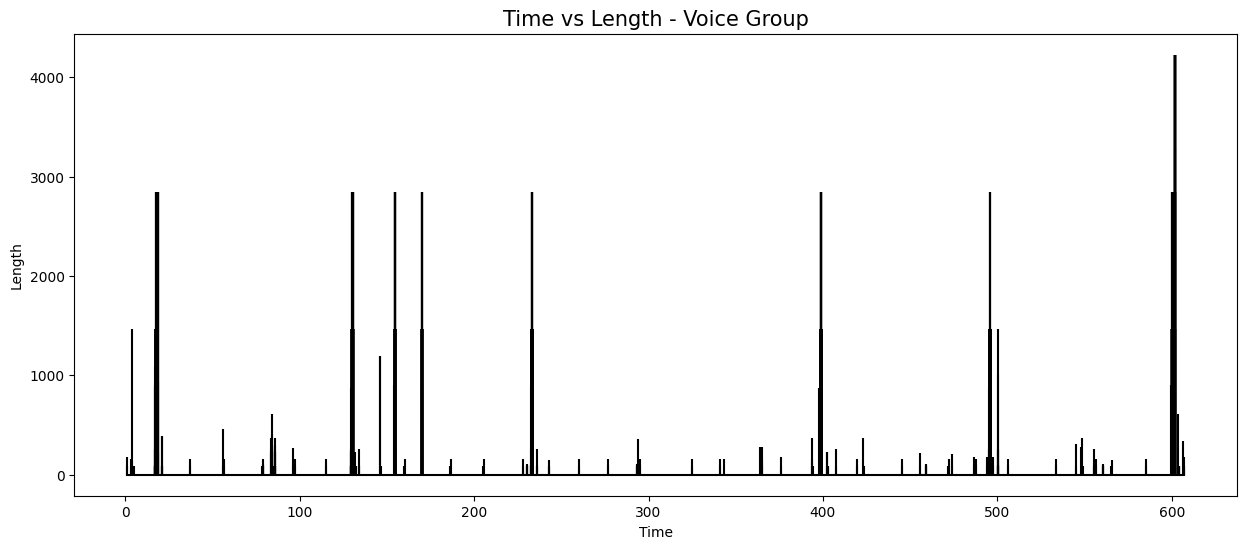

In [45]:
plot_graph(voice_data, 'Time vs Length - Voice Group')

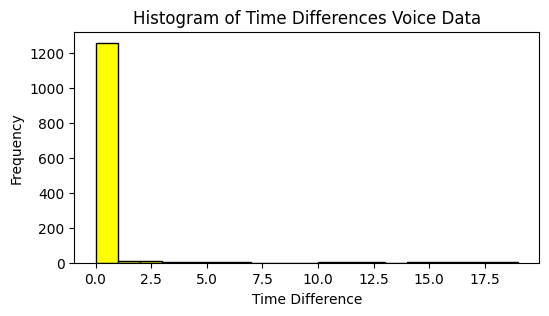

In [46]:
plot_hist(voice_data , 20, 'Histogram of Time Differences Voice Data')

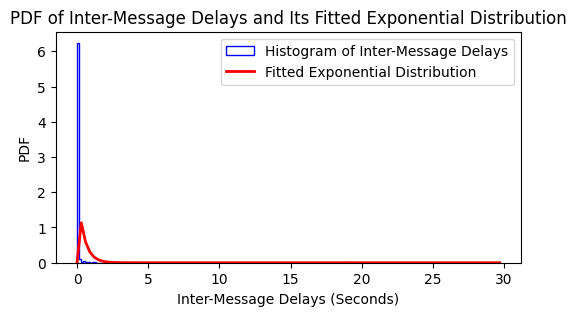

In [47]:
plot_pdf(voice_data)

### Text Group

In [48]:
text_data = pd.read_csv("../resources/Text Group/text_data.csv", encoding='latin-1')
text_data = text_data.loc[
    (text_data['Source'] == '2a03:2880:f258:c8:face:b00c:0:167') & 
    (text_data['Destination'] == '2a00:a041:3c5d:4d00:b981:f170:feac:7cf9')
]
text_data

,No.,Time,Source,Destination,Protocol,Length,Info
0,1,0.000000,2a03:2880:f258:c8:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TLSv1.2,176,Application Data
2,3,0.095351,2a03:2880:f258:c8:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TCP,88,443 > 39412 [ACK] Seq=89 Ack=73 Win=1537 Len...
3,5,7.679440,2a03:2880:f258:c8:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TLSv1.2,429,Application Data
5,7,7.766057,2a03:2880:f258:c8:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TCP,88,443 > 39412 [ACK] Seq=430 Ack=173 Win=1537 L...
6,8,7.767061,2a03:2880:f258:c8:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TLSv1.2,407,Application Data
...,...,...,...,...,...,...,...
1812,2201,627.309683,2a03:2880:f258:c8:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TCP,1468,443 > 39412 [ACK] Seq=36475 Ack=26874 Win=16...
1814,2203,627.309782,2a03:2880:f258:c8:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TLSv1.2,424,"Application Data, Application Data"
1816,2205,627.718916,2a03:2880:f258:c8:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TLSv1.2,229,Application Data
1820,2209,627.800928,2a03:2880:f258:c8:face:b00c:0:167,2a00:a041:3c5d:4d00:b981:f170:feac:7cf9,TCP,88,443 > 39412 [ACK] Seq=38332 Ack=26974 Win=16...


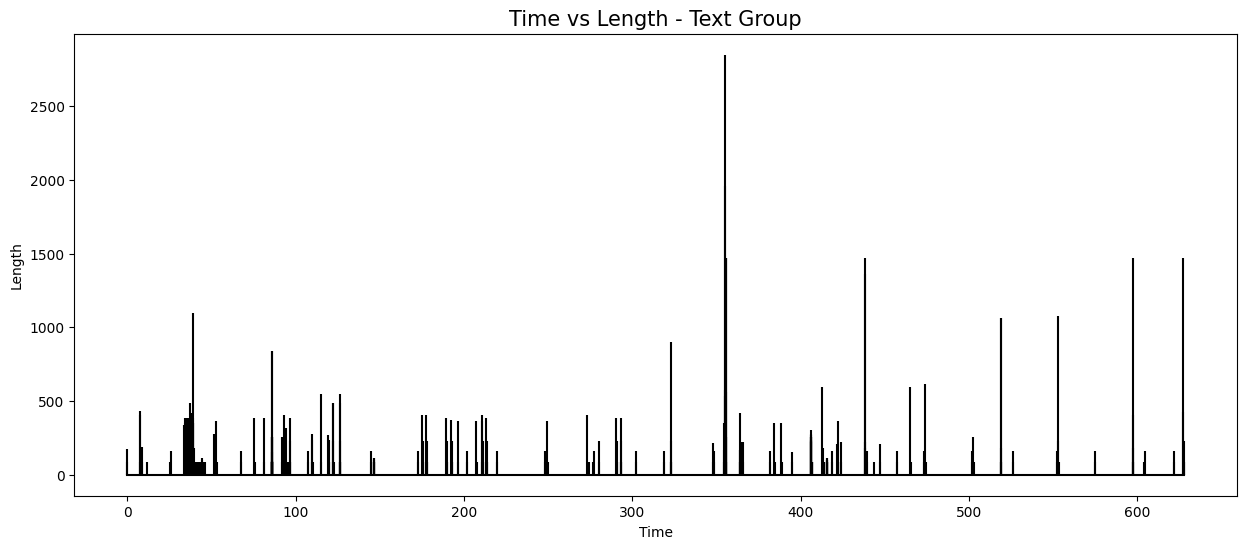

In [49]:
plot_graph(text_data, 'Time vs Length - Text Group')

To determine which data can be considered noise and filtered out,<br>
we conducted an experiment where we recorded the transmission of the smallest message size within the group.<br>
This experiment was performed twice, in two separate trials.

The data graphs from the experiment showed that any packets with a size less than 200 bytes were extraneous to the message transmission.<br> Based on these results, we can conclude that packets under 200 bytes can be assumed to be network noise unrelated to the core messages.<br> Therefore, packets smaller than 200 bytes can be safely filtered out without losing meaningful message data.

In [50]:
smallest_text_check1 = pd.read_csv("../resources/Text Group/smallest_text_data_first.csv", encoding='latin-1')
smallest_text_check1 = smallest_text_check1.loc[
    (smallest_text_check1['Source'] == '2a03:2880:f258:1c3:face:b00c:0:167') & 
    (smallest_text_check1['Destination'] == '2a00:a041:3c5d:4d00:424b:6377:a930:43d')
]
smallest_text_check2 = pd.read_csv("../resources/Text Group/smallest_text_data_second.csv", encoding='latin-1')
smallest_text_check2 = smallest_text_check2.loc[
    (smallest_text_check2['Source'] == '2a03:2880:f258:1c3:face:b00c:0:167') & 
    (smallest_text_check2['Destination'] == '2a00:a041:3c5d:4d00:424b:6377:a930:43d')
]

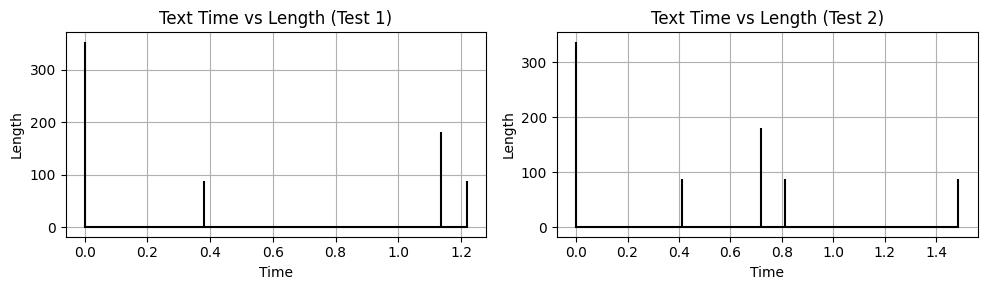

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,3)) 

test1_time = smallest_text_check1['Time']
test1_length = smallest_text_check1['Length']
ax1.stem(test1_time, test1_length, linefmt ='black', markerfmt = '', basefmt='black')
ax1.set_xlabel('Time')
ax1.set_ylabel('Length')
ax1.set_title('Text Time vs Length (Test 1)')
ax1.grid()

test2_time = smallest_text_check2['Time']
test2_length = smallest_text_check2['Length']
ax2.stem(test2_time, test2_length, linefmt ='black', markerfmt = '', basefmt='black') 
ax2.set_xlabel('Time')
ax2.set_ylabel('Length')
ax2.set_title('Text Time vs Length (Test 2)')
ax2.grid()
fig.tight_layout()
plt.show()

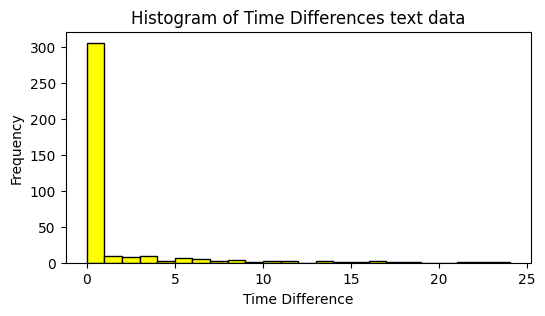

In [52]:
plot_hist(text_data, 25, 'Histogram of Time Differences text data')

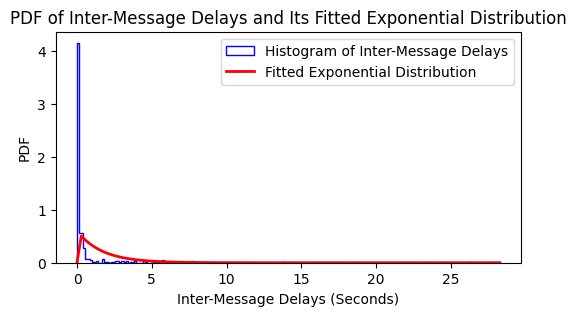

In [53]:
plot_pdf(text_data)

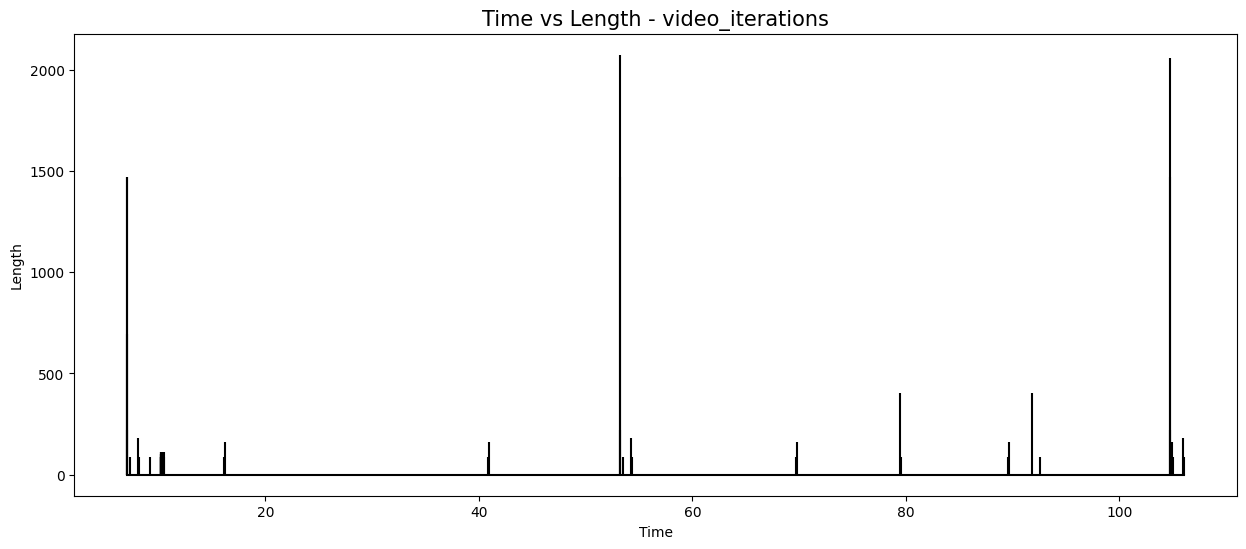

In [54]:
"""
We sent the same video 3 times, with a difference of 40 seconds between each sending, 
in order to observe how the data packets were transmitted. 
We filtered the network traffic (port = 443).
"""
video_iterations = pd.read_csv("../resources/Video Group/same_video_iterations.csv", encoding='latin-1')
video_iterations = video_iterations.loc[
    (video_iterations['Source'] == '2a03:2880:f258:1c3:face:b00c:0:167') & 
    (video_iterations['Destination'] == '2a00:a041:3c5d:4d00:424b:6377:a930:43d')
]
plot_graph(video_iterations, 'Time vs Length - video_iterations')

## Mix data

In [55]:
mix_data = pd.read_csv("../resources/Mix data Group/mix_data.csv", encoding='latin-1')
mix_data

,No.,Time,Source,Destination,Protocol,Length,Info
0,2,2.661957,2a03:2880:f258:1c3:face:b00c:0:167,2a00:a041:3c5d:4d00:424b:6377:a930:43d,TLSv1.2,184,Application Data
1,3,2.670534,2a00:a041:3c5d:4d00:424b:6377:a930:43d,2a03:2880:f258:1c3:face:b00c:0:167,TLSv1.2,183,Application Data
2,4,2.866356,2a03:2880:f258:1c3:face:b00c:0:167,2a00:a041:3c5d:4d00:424b:6377:a930:43d,TCP,88,443 > 41660 [ACK] Seq=97 Ack=96 Win=1242 Len...
3,5,8.010972,2a00:a041:3c5d:4d00:424b:6377:a930:43d,2a03:2880:f258:1c3:face:b00c:0:167,TLSv1.2,154,Application Data
4,6,8.088280,2a03:2880:f258:1c3:face:b00c:0:167,2a00:a041:3c5d:4d00:424b:6377:a930:43d,TCP,88,443 > 41660 [ACK] Seq=97 Ack=162 Win=1242 Le...
...,...,...,...,...,...,...,...
883,1125,337.500125,2a03:2880:f258:1c3:face:b00c:0:167,2a00:a041:3c5d:4d00:424b:6377:a930:43d,TCP,88,443 > 41660 [ACK] Seq=38157 Ack=16107 Win=12...
884,1126,337.884565,2a00:a041:3c5d:4d00:424b:6377:a930:43d,2a03:2880:f258:1c3:face:b00c:0:167,TLSv1.2,181,Application Data
885,1127,337.961362,2a03:2880:f258:1c3:face:b00c:0:167,2a00:a041:3c5d:4d00:424b:6377:a930:43d,TCP,88,443 > 41660 [ACK] Seq=38157 Ack=16200 Win=12...
886,1128,338.504061,2a00:a041:3c5d:4d00:424b:6377:a930:43d,2a03:2880:f258:1c3:face:b00c:0:167,TLSv1.2,181,Application Data


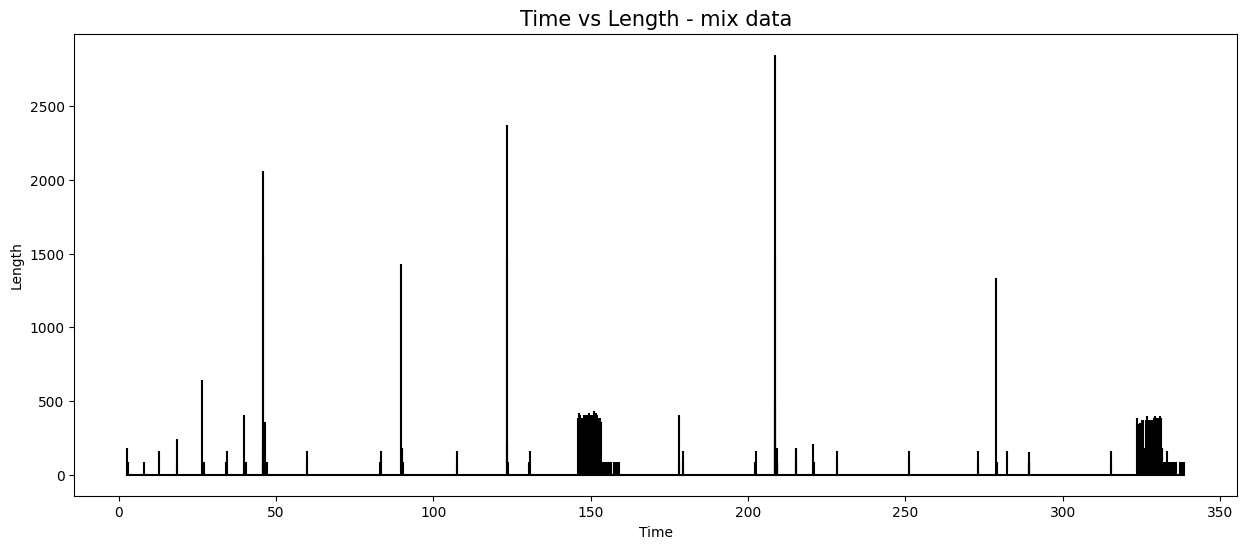

In [56]:
mix_data = mix_data.loc[
    (mix_data['Source'] == '2a03:2880:f258:1c3:face:b00c:0:167') & 
    (mix_data['Destination'] == '2a00:a041:3c5d:4d00:424b:6377:a930:43d')
]
plot_graph(mix_data, 'Time vs Length - mix data')

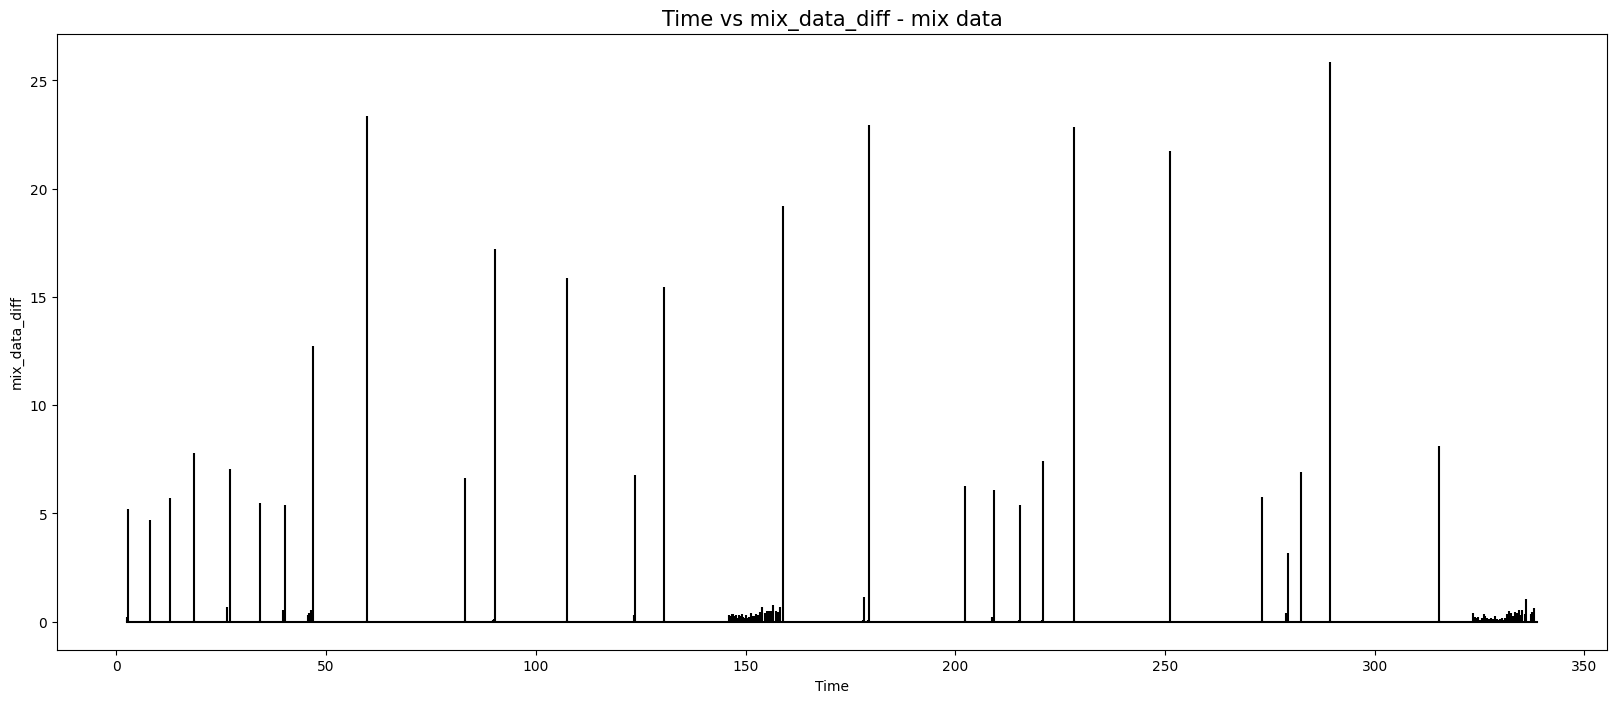

In [57]:
time = mix_data['Time']
mix_data_diff = mix_data['Time'].diff().shift(-1)
plt.figure(figsize=(20,8)) 
plt.stem(time, mix_data_diff,linefmt ='black',markerfmt = '', basefmt='black')
plt.xlabel('Time')
plt.ylabel('mix_data_diff')
plt.title('Time vs mix_data_diff - mix data' , fontsize = 15)
plt.show()

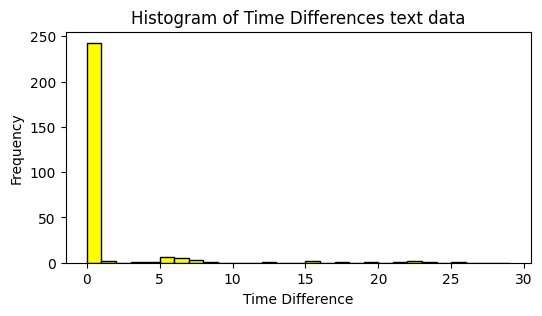

In [58]:
plot_hist(mix_data, 30 , 'Histogram of Time Differences text data')

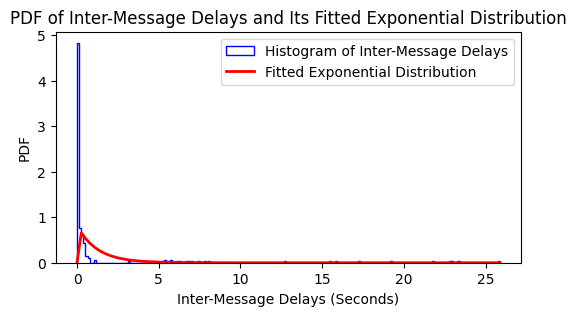

In [59]:
plot_pdf(mix_data)

In [60]:
video_data2 = pd.read_csv("../resources/Video Group/try.csv", encoding='latin-1')
video_data2

,No.,Time,Source,Destination,Protocol,Length,Info
0,16,2.359586,10.0.0.37,140.82.113.25,TLSv1.2,94,Application Data
1,17,2.359607,10.0.0.37,172.217.22.2,TCP,66,"32956 > 443 [FIN, ACK] Seq=1 Ack=1 Win=501 L..."
2,18,2.359996,10.0.0.37,140.82.113.25,TCP,94,"[TCP Retransmission] 53610 > 443 [PSH, ACK] ..."
3,19,2.360361,10.0.0.37,172.217.22.2,TCP,66,"[TCP Out-Of-Order] 32956 > 443 [FIN, ACK] Se..."
4,20,2.389700,172.217.22.2,10.0.0.37,TCP,80,443 > 32956 [ACK] Seq=1 Ack=2 Win=261 Len=0 ...
...,...,...,...,...,...,...,...
712,1038,25.284133,2a03:2880:f242:c8:face:b00c:0:167,2a10:8012:15:af5e:c336:78fe:e399:341e,TLSv1.3,264,Application Data
713,1039,25.287854,2a10:8012:15:af5e:c336:78fe:e399:341e,2a03:2880:f242:c8:face:b00c:0:167,TLSv1.3,184,Application Data
714,1040,25.293818,2a10:8012:15:af5e:c336:78fe:e399:341e,2a03:2880:f242:c8:face:b00c:0:167,TLSv1.3,184,Application Data
715,1041,25.335293,2a03:2880:f242:c8:face:b00c:0:167,2a10:8012:15:af5e:c336:78fe:e399:341e,TCP,86,443 > 52164 [ACK] Seq=92585 Ack=23912 Win=11...


### Text with Spotify at the backroud

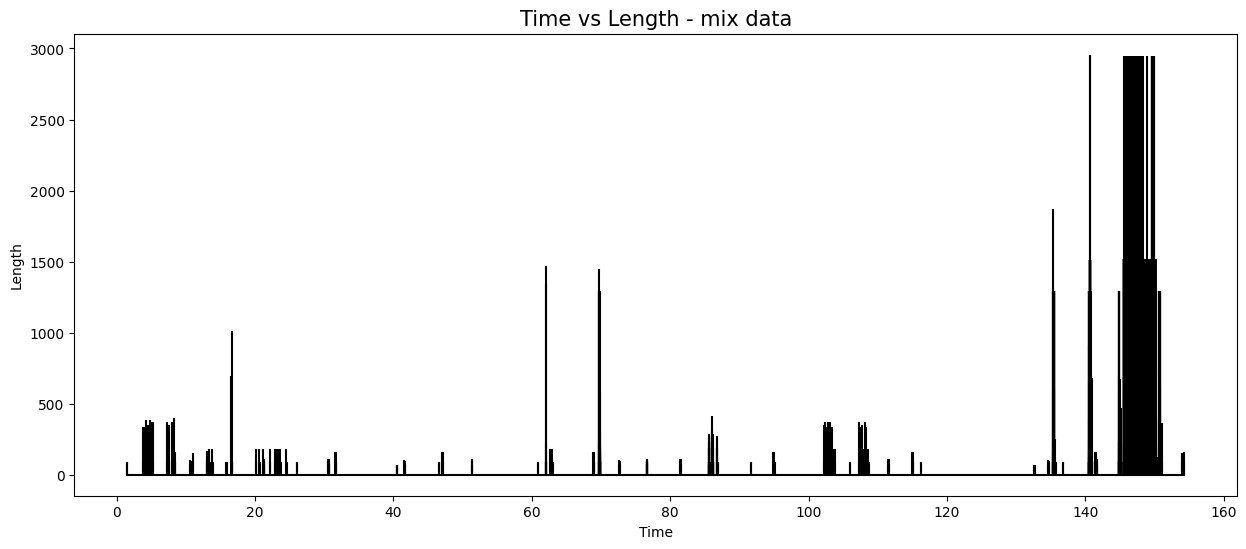

In [62]:
text_with_spotify = pd.read_csv('../resources/Mix data Group/text_with_spotify_data.csv')
# text_with_spotify = text_with_spotify.loc[
#     (text_with_spotify['Source'] == '2a03:2880:f258:1c3:face:b00c:0:167') & 
#     (text_with_spotify['Destination'] == '2a00:a041:3c5d:4d00:424b:6377:a930:43d')
#     |(text_with_spotify['Source'] == '2600:1901:1:c36::') |
#     (text_with_spotify['Destination'] == '2600:1901:1:c36::')
# ]
plot_graph(text_with_spotify, 'Time vs Length - mix data')

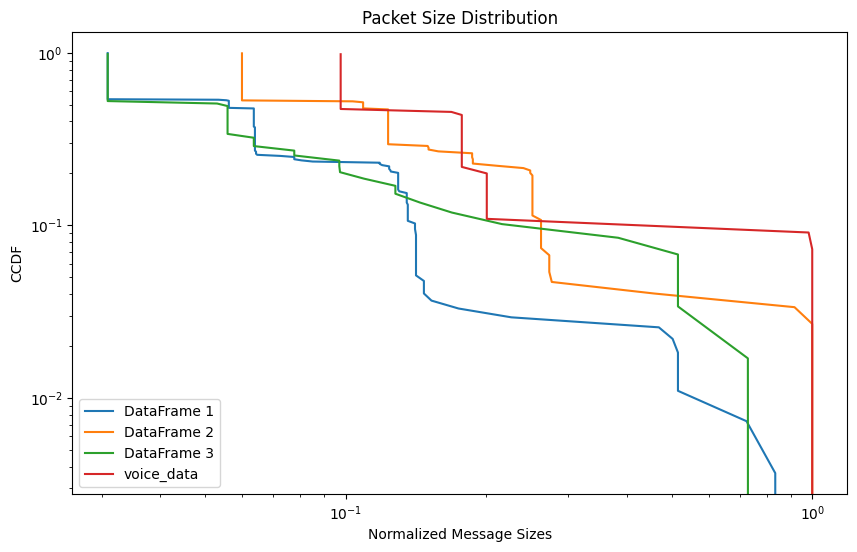

In [53]:

def compute_ccdf(column, threshold=0.7):
    """
    Compute Complementary Cumulative Distribution Function (CCDF) for a given dataframe column.
    
    Args:
        column (array-like): The data column for which to compute CCDF.
        
    Returns:
        normalized_vals (array-like): Normalized values of the data.
        ccdf (array-like): CCDF values corresponding to the data.
    """
    # Sort and normalize the data
    sorted_values = np.sort(column)
    normalized_values = sorted_values / max(sorted_values)

    # Compute CCDF
    cdf = np.arange(1, len(sorted_values) + 1) / len(sorted_values)
    ccdf = 1 - cdf
    
    return normalized_values, ccdf

def plot_ccdf(dataframes, labels):
    """
    Plot CCDF for a list of dataframes based on their 'Length' column.
    
    Args:
        dataframes (list): List of dataframes to plot.
        labels (list): Labels corresponding to each dataframe.
    """
    plt.figure(figsize=(10, 6))
    
    for df, label in zip(dataframes, labels):
        normalized_values, ccdf = compute_ccdf(df['Length'])
        plt.plot(normalized_values, ccdf, label=label)
    
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('Normalized Message Sizes')
    plt.ylabel('CCDF')
    plt.title('Packet Size Distribution')
    plt.legend(loc="lower left")
    plt.show()

# Example usage
dataframes_list = [mix_data, text_data, video_data, voice_data]  # List of your dataframes
labels_list = ['DataFrame 1', 'DataFrame 2', 'DataFrame 3', 'voice_data']  # Corresponding labels
plot_ccdf(dataframes_list, labels_list)